**rajvi using steph's code**

In [50]:
from rajvi_mapbox_api import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
import folium
from pyproj import Geod

In [51]:
branches = pd.read_csv('../data/clean/branches.csv')
populationDemographics = pd.read_csv('../data/clean/population_demographics.csv')

In [52]:
api = MapboxAPI()

In [56]:
branchRadii = gpd.read_file('../data/clean/branches.csv')

branchRadii = branchRadii.set_crs('EPSG:4326')
branchRadii[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchRadii['LOCATION']]
branchRadii.loc[:, 'LATITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LATITUDE'])
branchRadii.loc[:, 'LONGITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LONGITUDE'])
branchRadii.head()

#for i in range(branchRadii.shape[0]):
#    api_response =  api.get_data((branchRadii.loc[i,'LATITUDE'],branchRadii.loc[i,'LONGITUDE']), 5)
#    branchRadii.loc[i,'geometry'] = shape(api_response)

branchRadii = branchRadii.set_index('BRANCH')
api_response = api.get_data((branchRadii.loc['Albany Park','LATITUDE'],branchRadii.loc['Albany Park','LONGITUDE']), 5)
branchRadii.loc['Albany Park','geometry'] = shape(api_response)

/tmp/ipykernel_1716550/3834977753.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
/tmp/ipykernel_1716550/3834977753.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]


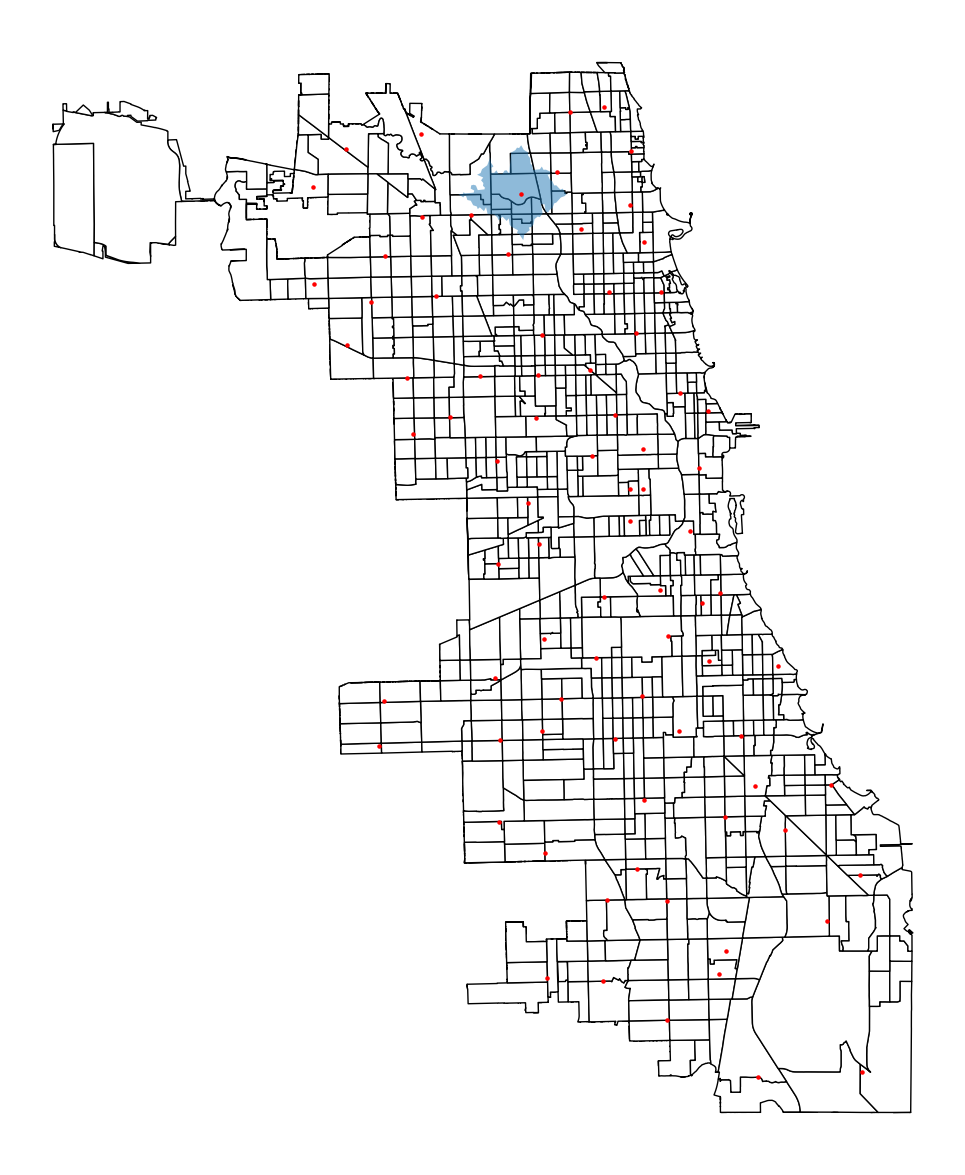

In [57]:
# this line makes a copy of the ageOnly data frame so we can manipulate without affecting our primary dataset
censusTracts = populationDemographics[['geoid','geometry','qualifying name', 'current land area (sq. m)', 'current water area (sq. m)', ]]
branchLocsOnly=branches[['BRANCH','LOCATION']]

# the following converts the data frame to a geo data frame and plots estimated percent of retired members of each community
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

branchLocsOnly.crs = 'EPSG:4326'
branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
branchLocsOnly = branchLocsOnly.drop(columns='LOCATION')
#branchLocsOnly.head()

branchLocsOnly = gpd.GeoDataFrame(
    branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:4326")
    #branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:32633")

fig, ax = plt.subplots(1, figsize=(15, 15))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
ax.axis('off')

branchRadii.plot(ax=base, alpha = .5)
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);


In [58]:
albanyPark=pd.DataFrame
albanyPark = pd.DataFrame(columns=['Census Tract','geometry'])
areaCalculations = pd.DataFrame(columns=['Census Tract','geometry'])
albanyPark.reset_index(inplace = True)

# for loop to make dataframe of overlapping census tracts with the names of each census tract and polygon of area covered
# for loop also adds to new data frame which is collecting the name and geometry of the entire census tract that is partially or fully covered by
# the radius

geod=Geod(ellps='WGS84')
censusAreas = []


for index, row in censusTracts.iterrows():
    if ((branchRadii.intersection(row['geometry']))[0]).is_empty:
        empty=[]
        empty.append("none")
    else:
        temp = pd.DataFrame({"Census Tract": row['geoid'],"geometry": [(branchRadii.intersection(row['geometry'])[0])]}, index=[0])
        albanyPark=pd.concat([albanyPark,temp])
        geomTemp = pd.DataFrame({"Census Tract": row['geoid'],"geometry": [(row['geometry'])]})
        areaCalculations = pd.concat([areaCalculations, geomTemp])


for index, row in areaCalculations.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area / -10**6
    censusAreas.append(poly_area)
    
areaCalculations['calculated area'] = censusAreas
areaCalculations.reset_index(inplace = True)

/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [65]:
# convert albanyPark to geodata frame and reasssign to crs used for area calculations (by default, its 4326 geometries)
albanyPark = gpd.GeoDataFrame(albanyPark, crs="epsg:4326")

albanyPark.reset_index(inplace = True)

geod=Geod(ellps='WGS84')

overlappingAreas = []

for index, row in albanyPark.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area / -10**6
    overlappingAreas.append(poly_area)

albanyPark['Area Within Radius']= overlappingAreas
albanyPark['census Area'] = areaCalculations['calculated area']

# using Geod method with WGS84 and espg:4326 gives us area in DEGREES not meters so the proportion is accurate but 
# the actual area values you have to convert to a different crs to be useful as distances

In [66]:
albanyPark = albanyPark.drop(columns='level_0')
albanyPark['Percent Overlap'] = albanyPark['Area Within Radius']/albanyPark['census Area']

In [67]:
albanyPark = albanyPark.drop(columns='index')
albanyPark

,Census Tract,geometry,Area Within Radius,census Area,Percent Overlap
0,17031140800,"POLYGON ((-87.70461 41.96728, -87.70561 41.967...",0.079196,0.725871,0.109105
1,17031160501,"POLYGON ((-87.71208 41.96105, -87.71261 41.959...",0.024018,0.345246,0.069568
2,17031140702,"POLYGON ((-87.71461 41.96119, -87.71562 41.961...",0.327603,0.427093,0.767052
3,17031140601,"POLYGON ((-87.72461 41.96616, -87.72505 41.967...",0.027171,0.272125,0.099847
4,17031140602,"POLYGON ((-87.71835 41.96384, -87.71916 41.964...",0.111515,0.384382,0.290116
5,17031140701,"POLYGON ((-87.71728 41.96836, -87.71703 41.968...",0.228328,0.228328,1.000000
6,17031140301,"POLYGON ((-87.72803 41.96829, -87.72803 41.968...",0.163895,0.164127,0.998586
7,17031140200,"POLYGON ((-87.71739 41.97257, -87.71714 41.972...",0.394454,0.394454,1.000000
8,17031140100,"POLYGON ((-87.70398 41.97195, -87.70321 41.968...",0.253816,0.287982,0.881359
9,17031140302,"POLYGON ((-87.72755 41.97554, -87.72738 41.975...",0.414719,0.414719,1.000000


In [68]:
#altgeldCensusOverlap
#altgeldCensusOverlap.to_csv('../individual lib census/altgeldCensusOverlap.csv')